# Inverted emissions

In [1]:
import numpy as np
import pandas as pd
import openpyxl
from scipy.interpolate import make_smoothing_spline
from mce.core import ScenarioBase
from mce.util.io import RetrieveGitHub
from mce.core.forcing import RfAll
from mce.util.plot_base import PlotBase

In [2]:
forcing = RfAll()
myplt = PlotBase(palette='ipcc_wg1')

## Input data

In [81]:
# CH4 and N2O emissions from IGCC
repo = RetrieveGitHub('ClimateIndicator', 'GHG-Emissions-Assessment', 'datain')

path = repo.retrieve('results/ghg_emissions_co2e_2024.xlsx')
wb = openpyxl.load_workbook(path, read_only=True, data_only=True)

rows = wb['data_original_units'].iter_rows(
    max_col=5, max_row=1159, values_only=True,
)
columns = next(rows)
df = pd.DataFrame(list(rows), columns=columns)

wb.close()

[2025-03-18 14:17:49 mce.util.io] INFO:Use local file datain/ClimateIndicator/GHG-Emissions-Assessment/results/ghg_emissions_co2e_2024.xlsx retrieved from https://github.com/ClimateIndicator/GHG-Emissions-Assessment/raw/main/results/ghg_emissions_co2e_2024.xlsx on 2025-03-17


In [82]:
df

,label,source,units,year,value
0,CO2-FFI,GCB v2023*,GtCO2,1959,8.815119
1,CO2-FFI,GCB v2023*,GtCO2,1960,9.343085
2,CO2-FFI,GCB v2023*,GtCO2,1961,9.367893
3,CO2-FFI,GCB v2023*,GtCO2,1962,9.696157
4,CO2-FFI,GCB v2023*,GtCO2,1963,10.212458
...,...,...,...,...,...
1153,N2O,GFED v4.1*,MtN2O,2019,0.997000
1154,N2O,GFED v4.1*,MtN2O,2020,0.859000
1155,N2O,GFED v4.1*,MtN2O,2021,1.058000
1156,N2O,GFED v4.1*,MtN2O,2022,0.706000


In [83]:
id_vars = ['label', 'source', 'units']
df = {
    k: v
    .drop(id_vars, axis=1).set_index('year')
    .squeeze().rename(int).rename_axis(None)
    for k, v in df.groupby(id_vars) if k[0] != 'CO2-FFI'
}

In [84]:
dfin = pd.concat(df, axis=1)

In [86]:
dfin

CH4                          N2O                  
     GFED v4.1* PRIMAP CR v2.5.1* GFED v4.1* PRIMAP CR v2.5.1*
          MtCH4             MtCH4      MtN2O             MtN2O
1750     11.317              26.9      0.763             0.121
1751     11.103              27.0      0.751             0.123
1752     10.994              27.1      0.747             0.124
1753     11.087              27.1      0.748             0.125
1754     11.361              27.2      0.766             0.126
...         ...               ...        ...               ...
2019     17.840             305.0      0.997            10.300
2020     12.700             303.0      0.859            10.400
2021     15.580             307.0      1.058            10.500
2022     10.320             312.0      0.706            10.600
2023     22.170               NaN      1.376               NaN

[274 rows x 4 columns]

In [87]:
# Tentative update for 2023 with PRIMAP v2.6 based on changes from 2022
# csv data were downloaded at
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=ch4
# and
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=n2o
df = pd.DataFrame({
    gas:
    pd.read_csv(f'datain/PRIMAP/v2.6/HISTCR_EARTH_{gas}_Mt.csv', index_col=0)
    .sum(axis=1)
    for gas in ['CH4', 'N2O']
}).rename_axis(None)

d1 = df.loc[2023] - df.loc[2022]

for gas in ['CH4', 'N2O']:
    unit = f'Mt{gas}'
    dfin.loc[2023, (gas, 'PRIMAP CR v2.5.1*', unit)] = (
        dfin.loc[2022, (gas, 'PRIMAP CR v2.5.1*', unit)]
        + d1[gas]
    )

In [88]:
dfin

CH4                          N2O                  
     GFED v4.1* PRIMAP CR v2.5.1* GFED v4.1* PRIMAP CR v2.5.1*
          MtCH4             MtCH4      MtN2O             MtN2O
1750     11.317            26.900      0.763             0.121
1751     11.103            27.000      0.751             0.123
1752     10.994            27.100      0.747             0.124
1753     11.087            27.100      0.748             0.125
1754     11.361            27.200      0.766             0.126
...         ...               ...        ...               ...
2019     17.840           305.000      0.997            10.300
2020     12.700           303.000      0.859            10.400
2021     15.580           307.000      1.058            10.500
2022     10.320           312.000      0.706            10.600
2023     22.170           311.661      1.376            10.651

[274 rows x 4 columns]

In [89]:
# Total emissions
df = dfin.T.groupby(level=0).sum().T.rename_axis(None, axis=1)

In [90]:
df

,CH4,N2O
1750,38.217,0.884
1751,38.103,0.874
1752,38.094,0.871
1753,38.187,0.873
1754,38.561,0.892
...,...,...
2019,322.840,11.297
2020,315.700,11.259
2021,322.580,11.558
2022,322.320,11.306


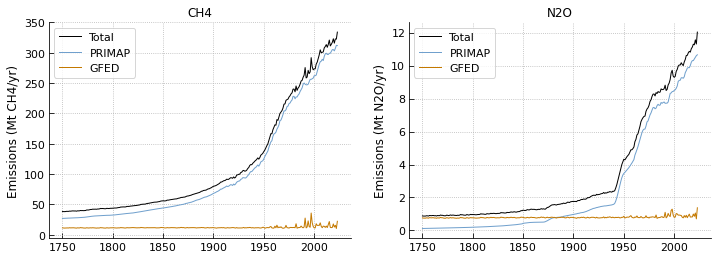

In [10]:
myplt.init_regular(2, col=2)

unit_w = 'Mt'

for ax, (gas, d0) in zip(myplt(), df.items()):
    d1 = dfin[(gas, 'PRIMAP CR v2.5.1*', f'{unit_w}{gas}')]
    d2 = dfin[(gas, 'GFED v4.1*', f'{unit_w}{gas}')]
    ax.plot(d0.index, d0, label='Total')
    ax.plot(d1.index, d1, label='PRIMAP')
    ax.plot(d2.index, d2, label='GFED')
    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w} {gas}/yr'
    ax.set_ylabel(f'Emissions ({units})')
    ax.grid()

In [11]:
df_emis = df

In [12]:
ds = ScenarioBase(outpath='untracked/scenarios.h5', mode='a')

[2025-03-18 11:13:39 mce.core] INFO:untracked/scenarios.h5 already exists
[2025-03-18 11:13:39 mce.core] INFO:file untracked/scenarios.h5 opened with mode=a


In [13]:
# 'historical/input was created in mk_forcing_ar6__02.ipynb
list(ds.file['historical/input'])

['conc', 'emis_co2', 'emis_slcf', 'erf_other']

In [16]:
ds_hist = ds.get_scenario('historical')

df_conc = pd.DataFrame(
    ds_hist['conc']['data'],
    index=ds_hist['conc']['time'],
    columns=ds_hist['conc']['variables'],
)

In [17]:
df_conc.shape, df_emis.shape

((275, 52), (274, 2))

In [18]:
# Adjust df_conc index
df_conc = df_conc.reindex(df_emis.index)

In [19]:
# Ensure that concentrations are given at 1-year intervals
time = df_conc.index.values
len(time), np.all(time[1:] - time[:-1] == 1)

(274, True)

In [21]:
# Check units
gases = ['CH4', 'N2O']
for gas in gases:
    print(
        '{} emis: {}, conc: {}'.format(
            gas,
            f'{unit_w} {gas}/yr',
            ds_hist['conc']['attrs'][gas]['units'],
        )
    )

CH4 emis: Mt CH4/yr, conc: ppb
N2O emis: Mt N2O/yr, conc: ppb


## Inverted natural emissions of CH4 and N2O

In [22]:
gases = ['CH4', 'N2O']
unit_c = 'ppb'

w2cs = []
lifes = []

for gas in gases:
    w2cs.append(forcing.weight2conc(1, unit_w, gas, unit_c))
    lifes.append(forcing.ghgs[gas].lifetime)

w2cs = np.array(w2cs)
lifes = np.array(lifes)

In [23]:
lifes, w2cs

(array([ 11.8, 109. ]), array([0.35322459, 0.12873716]))

In [24]:
lam = 200. # control parameter for smoothness and proximity

df_raw = {}
df_spl = {}

for gas, life, w2c in zip(gases, lifes, w2cs):
    # Observed concentrations
    d0 = df_conc[gas]
    # Inverted emissions (natural + anthropogenic)
    d0_inv = (
        pd.Series(np.gradient(d0), index=d0.index) + d0 / life
    ) / w2c

    # Anthropogenic emissions
    d1 = df_emis[gas]
    # Inverted natural emissions
    d2 = d0_inv - d1
    spl = make_smoothing_spline(d2.index, d2, lam=lam)
    df_raw[gas] = d2
    df_spl[gas] = pd.Series(spl(d2.index), index=d2.index)

df_raw = pd.DataFrame(df_raw)
df_spl = pd.DataFrame(df_spl)

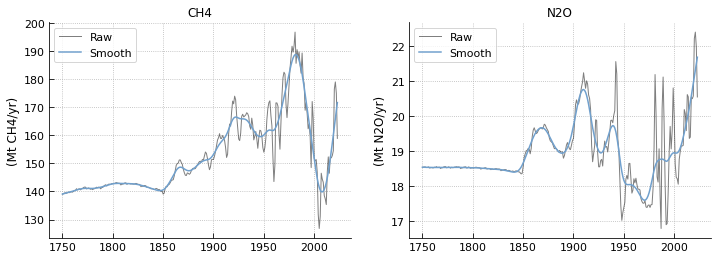

In [25]:
myplt.init_regular(2, col=2)

for ax, gas in zip(myplt(), gases):
    d0 = df_raw[gas].squeeze()
    d1 = df_spl[gas].squeeze()
    ax.plot(d0.index, d0, alpha=0.5, label='Raw')
    ax.plot(d1.index, d1, lw=1.5, label='Smooth')
    ax.legend()
    ax.set_ylabel(f'({unit_w} {gas}/yr)')
    ax.set_title(gas)
    ax.grid()

In [26]:
df_emis_natural = df_spl
df_emis_natural

,CH4,N2O
1750,139.089461,18.528125
1751,139.187113,18.527241
1752,139.284137,18.526319
1753,139.380267,18.525340
1754,139.475993,18.524329
...,...,...
2019,160.235753,20.939855
2020,163.201854,21.132143
2021,166.112977,21.318197
2022,168.937559,21.496073


## Inverted emissions of halogens

In [27]:
df_conc = pd.DataFrame(
    ds_hist['conc']['data'],
    index=ds_hist['conc']['time'],
    columns=ds_hist['conc']['variables'],
).drop(['CO2', 'CH4', 'N2O'], axis=1)

In [28]:
df_conc

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-1301,Halon-2402,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
1750,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1751,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1752,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1753,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1754,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,4.940000,0.70,0.11984,0.097,77.000,86.40,223.9,0.4,0.0704,69.20,...,3.320,0.4,2.3,10.270,2.600000,1.8114,0.0690,0.2073,0.1528,0.2312
2021,5.030000,0.72,0.12132,0.098,76.000,87.40,221.6,0.4,0.0712,68.60,...,3.330,0.4,2.5,10.650,2.700000,1.8742,0.0704,0.2114,0.1564,0.2328
2022,5.150000,0.74,0.12280,0.099,75.000,88.50,219.3,0.4,0.0720,68.10,...,3.330,0.4,2.7,11.040,2.800000,1.9370,0.0718,0.2155,0.1600,0.2344
2023,5.200000,0.76,0.12428,0.100,73.800,89.00,217.0,0.4,0.0728,67.60,...,3.330,0.4,2.9,11.390,2.900000,1.9998,0.0732,0.2196,0.1636,0.2360


In [29]:
# Ensure that all the units are ppt
set([
    ds_hist['conc']['attrs'][gas]['units']
    for gas in df_conc
])

{'ppt'}

In [30]:
unit_w = 'kt'
unit_c = 'ppt'

lifes = np.array([forcing.ghgs[gas].lifetime for gas in df_conc])
w2cs = np.array([
    forcing.weight2conc(1, unit_w, gas, unit_c)
    for gas in df_conc
])

In [31]:
# Ensure that input concentrations are given at 1-year intervals
time = df_conc.index.values
np.all(time[1:] - time[:-1] == 1)

True

In [32]:
# Inverted emissions
yin = df_conc.values
xinv = (np.gradient(yin, axis=0) + yin / lifes) / w2cs

In [33]:
df_emis_inv = pd.DataFrame(xinv, index=time, columns=df_conc.columns)

In [34]:
df_emis_inv

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-1301,Halon-2402,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
1750,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1751,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1752,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1753,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1754,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2.204322e+00,0.672645,0.104102,0.079818,39.536066,14.782239,48.631490,0.226264,0.077487,4.765295,...,1.343334,0.655118,2.556955,9.105593,3.102341,2.212444,0.084858,0.175600,0.184909,0.099912
2021,2.569923e+00,0.672900,0.104136,0.079843,37.330191,16.335750,47.559079,0.226264,0.078040,6.205552,...,1.346984,0.655118,2.561359,10.010940,3.152378,2.237850,0.084885,0.175666,0.184954,0.099943
2022,2.083040e+00,0.673156,0.104170,0.079869,33.766855,12.453092,46.486668,0.226264,0.078594,7.681371,...,1.215571,0.655118,2.565764,9.627388,3.202416,2.238543,0.084912,0.175733,0.184998,0.099974
2023,1.924830e+00,0.673411,0.104204,0.079895,33.834728,12.375587,45.414258,0.226264,0.079147,6.015296,...,1.281277,0.655118,2.570169,9.307963,3.252454,2.239236,0.084939,0.175799,0.185043,0.100005


In [35]:
repo = RetrieveGitHub('ClimateIndicator', 'forcing-timeseries', 'datain')
path = repo.retrieve('output/ghg_equivalent_emissions.csv')
df_emis_ref = pd.read_csv(path, index_col=0).rename(int)

[2025-03-18 11:23:30 mce.util.io] INFO:Use local file datain/ClimateIndicator/forcing-timeseries/output/ghg_equivalent_emissions.csv retrieved from https://github.com/ClimateIndicator/forcing-timeseries/raw/main/output/ghg_equivalent_emissions.csv on 2025-03-18


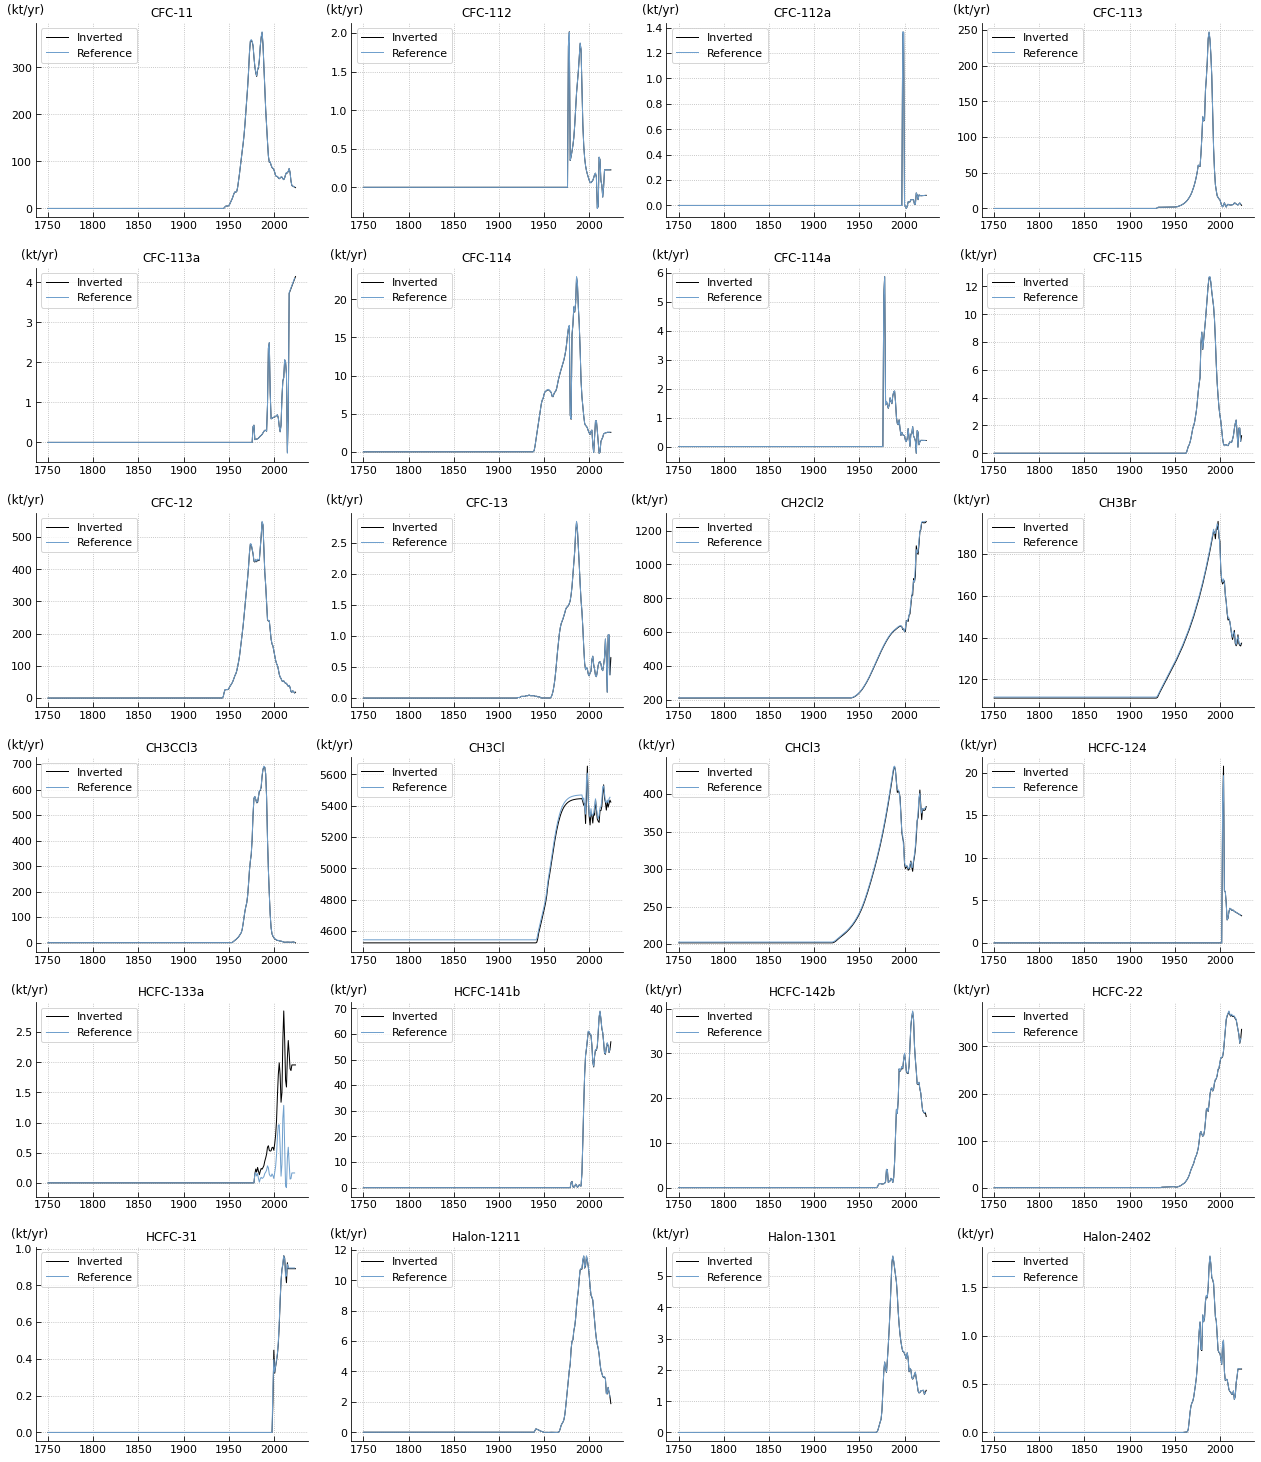

In [39]:
gases = [
    # chlorofluorocarbons (CFC), hydrofluorochlorocarbons (HCFC),
    # chlorocarbons, hydrochlorocarbons,
    # bromocarbons, hydrobromocarbons, and halons
    'CFC-11', 'CFC-112', 'CFC-112a', 'CFC-113', 'CFC-113a', 'CFC-114',
    'CFC-114a', 'CFC-115', 'CFC-12', 'CFC-13', 'CH2Cl2',
    'CH3Br', 'CH3CCl3', 'CH3Cl', 'CHCl3',
    'HCFC-124', 'HCFC-133a', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HCFC-31',
    'Halon-1211', 'Halon-1301', 'Halon-2402',
]
kw_space = {'height': 2.7, 'wspace': 0.6}
kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}

myplt.init_regular(len(gases), col=4, kw_space=kw_space)

for ax, gas in zip(myplt(), gases):
    d0 = df_emis_inv[gas]
    d1 = df_emis_ref[gas]
    ax.plot(d0.index, d0, label='Inverted')
    ax.plot(d1.index, d1, label='Reference')
    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w}/yr'
    ax.set_ylabel(f'({units})', **kw_ylabel)
    ax.grid()

In [40]:
forcing.ghgs['HCFC-133a']

Molecule(name='HCFC-133a', category='montreal_gases', formula='CH2ClCF3', weight=118.49, efficiency=0.14995, lifetime=4.6)

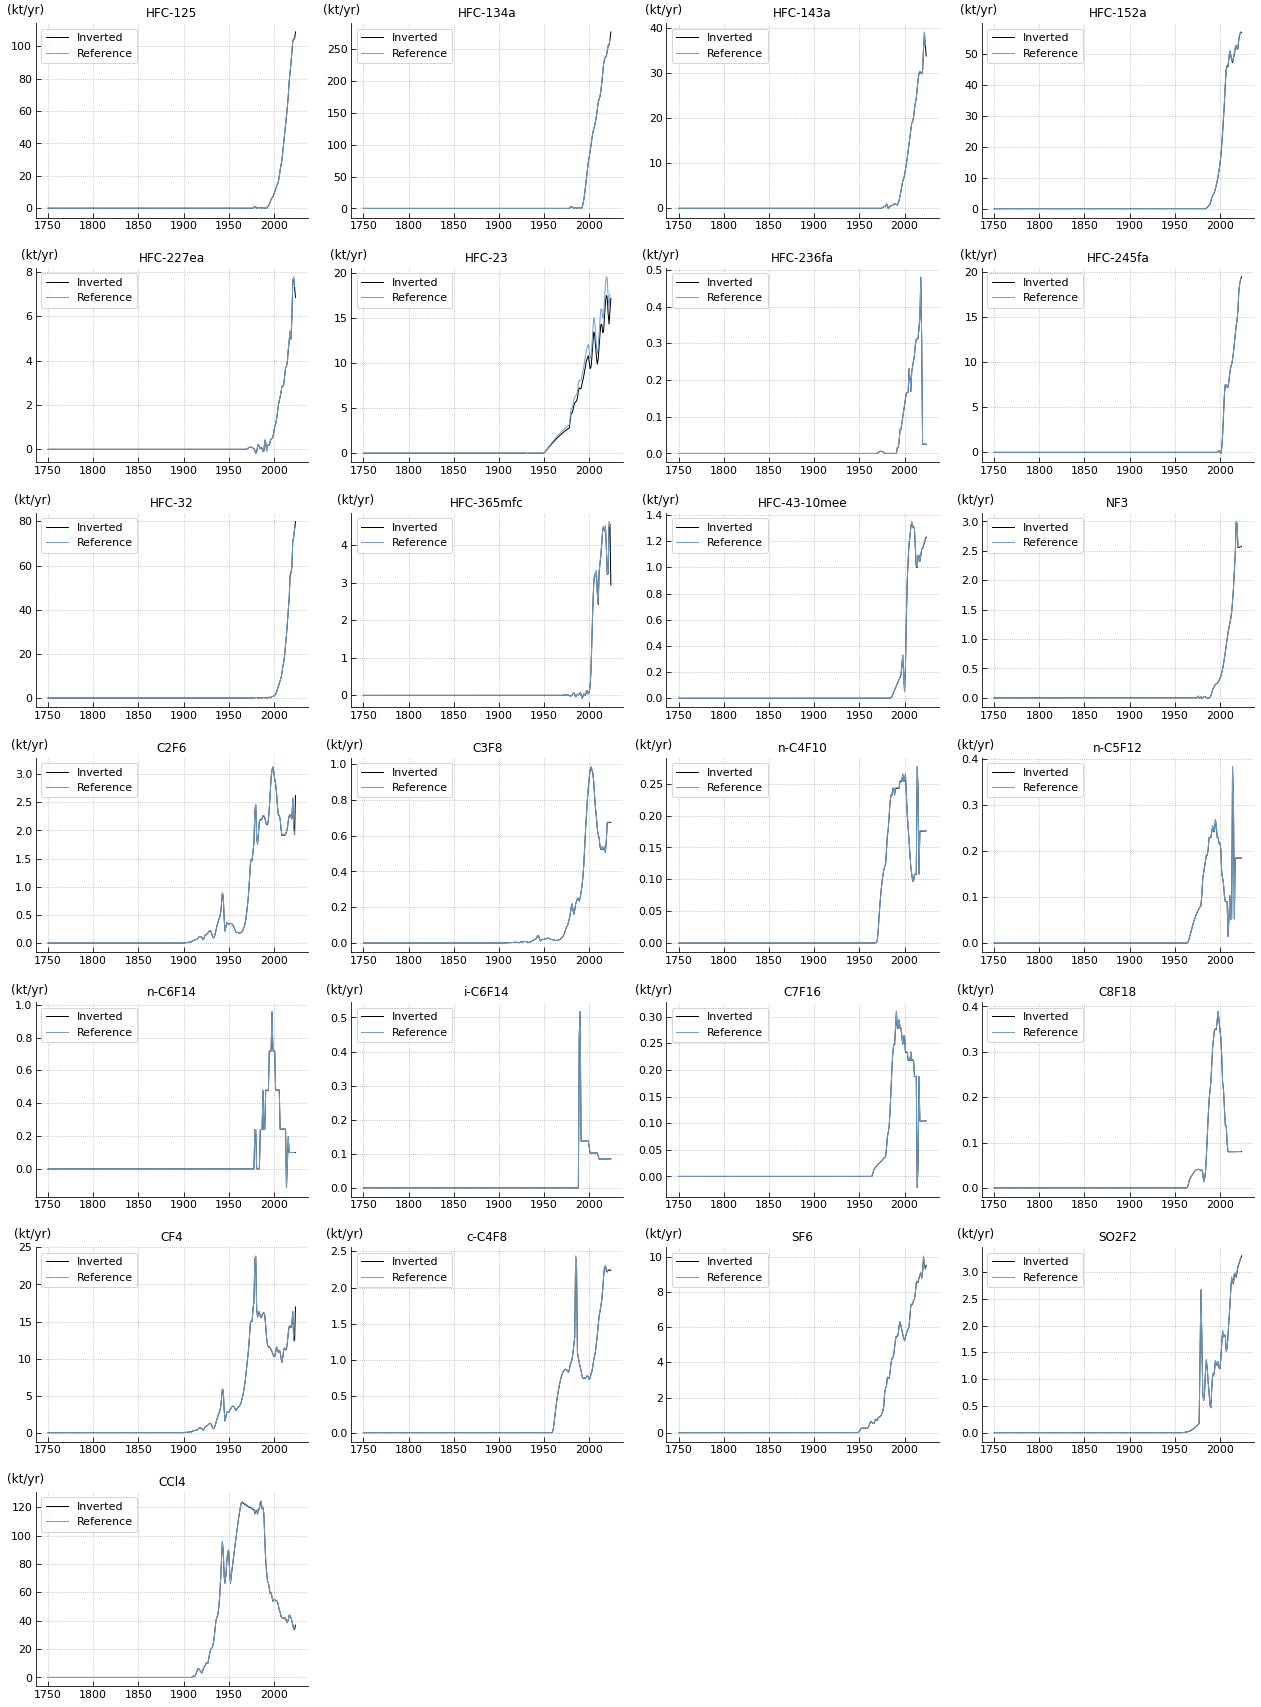

In [41]:
gases = [
    # hydrofluorocarbons (HFC) and fully fluorinated species including perfluorocarbons (PFCs)
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23',
    'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee',
    'NF3', 'C2F6', 'C3F8', 'n-C4F10', 'n-C5F12', 'n-C6F14', 'i-C6F14',
    'C7F16', 'C8F18', 'CF4', 'c-C4F8', 'SF6', 'SO2F2', 'CCl4',
]

myplt.init_regular(len(gases), col=4, kw_space=kw_space)

for ax, gas in zip(myplt(), gases):
    d0 = df_emis_inv[gas]
    d1 = df_emis_ref[gas]
    ax.plot(d0.index, d0, label='Inverted')
    ax.plot(d1.index, d1, label='Reference')
    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w}/yr'
    ax.set_ylabel(f'({units})', **kw_ylabel)
    ax.grid()

## Save data

In [47]:
ds.file['historical/input/emis_co2/FFI'].attrs['units']

'Gt C yr-1'

In [ ]:
df = pd.concat([df_emis, df_emis_inv], axis=1)

gout = ds.file['historical/input'].create_group('emis_ghg')
year = df.index.values
dset = gout.create_dataset('time', data=year)
dset.attrs['units'] = 'yr'

map_units = {'CH4': 'Mt', 'N2O': 'Mt'}
for gas, v in df.items():
    dset = gout.create_dataset(gas, data=v.values)
    dset.attrs['units'] = '{} {} yr-1'.format(
        gas, map_units.get(gas, 'kt'),
    )

In [51]:
ds.file['historical/input/emis_ghg']

<HDF5 group "/historical/input/emis_ghg" (52 members)>

In [52]:
df = df_emis_natural

gout = ds.file['historical/input'].create_group('emis_natural')
year = df.index.values
dset = gout.create_dataset('time', data=year)
dset.attrs['units'] = 'yr'

for gas, v in df.items():
    dset = gout.create_dataset(gas, data=v.values)
    dset.attrs['units'] = f'Mt {gas} yr-1'

In [54]:
ds.file['historical/input/emis_natural']

<HDF5 group "/historical/input/emis_natural" (3 members)>

In [55]:
ds.close()

[2025-03-18 11:44:11 mce.core] INFO:file untracked/scenarios.h5 closed
